In [2]:
import numpy as np
from scipy.optimize import minimize_scalar
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
frontier_jobs = pd.read_csv("jobs2024.csv")

frontier_jobs


,Node Count,Requested Duration,Actual Duration
0,2064,28800,28822
1,2023,43200,4
2,4096,43200,10812
3,1500,43200,33736
4,150,21600,6
...,...,...,...
331635,4,300,15
331636,2,1920,185
331637,4,300,17
331638,4,300,25


In [4]:
jobs = frontier_jobs.loc[:,["Node Count", "Actual Duration", "Requested Duration"]]
jobs = jobs.to_numpy().astype(np.float64)
jobs[:,1:] = jobs[:,1:]/3600 # Hours, not seconds

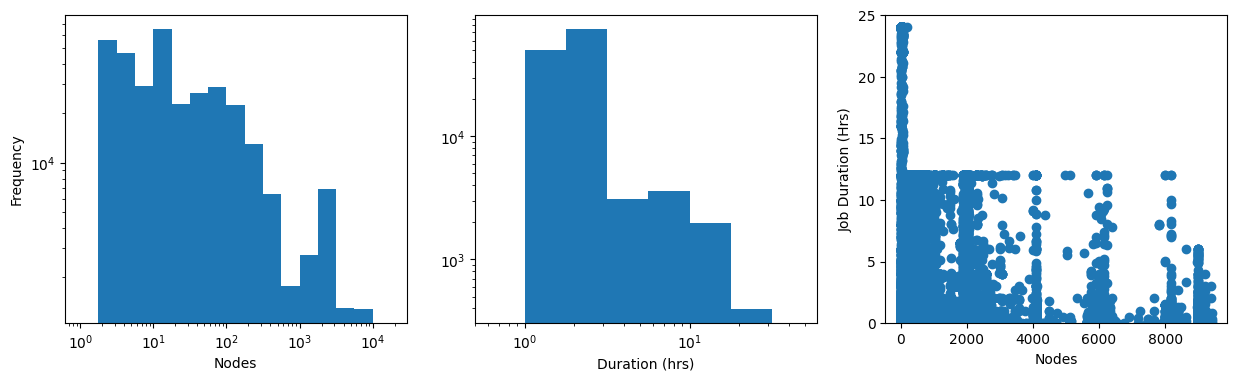

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
ax = axs[0]
bins = 10**(np.arange(18)*0.25)
ax.hist(jobs[:,0], bins=bins, log=True)
ax.set_xscale("log")
# ax.set_xlim(xmin=9.0)
ax.set_xlabel("Nodes")
ax.set_ylabel("Frequency")

ax = axs[1]
bins = 10**((np.arange(8))*0.25)
ax.hist(jobs[:,1], bins=bins, log=True)
ax.set_xlim(xmin=0.5)
ax.set_xscale("log")
ax.set_xlabel("Duration (hrs)")

ax = axs[2]
ax.scatter(jobs[:,0], jobs[:,1])
ax.set_ylim(ymin=0,ymax=25)
ax.set_xlabel("Nodes")
ax.set_ylabel("Job Duration (Hrs)")

plt.show()

In [6]:
avg_jobsize = jobs[:,0].mean()
avg_duration = jobs[:,1].mean()
max_jobsize = jobs[:,0].max()
max_duration = jobs[:,1].max()
actual_usage = jobs[:,0]*jobs[:,1]
requested_usage = jobs[:,0]*jobs[:,2]
max_usage = actual_usage.max()
usage_ratio = actual_usage.mean() / requested_usage.mean()

jobs_analysis = np.zeros((jobs.shape[0], 2))
jobs_analysis[:,0] = jobs[:,0]
jobs_analysis[:,1] = jobs[:,2] * usage_ratio


print(f"Number of selected jobs: {jobs.shape[0]:d}")
print(f"Average job size = {avg_jobsize:.2f} ; Average job duration = {avg_duration:.3f} hrs")
print(f"Maximum job size = {int(max_jobsize):d} ; Maximum job duration = {max_duration:.3f} hrs")
print(f"Maximum job usage = {max_usage:.3f} node-hrs")
print(f"Ratio of mean actual usage to mean requested usage = {usage_ratio:.3f}")

Number of selected jobs: 331640
Average job size = 142.09 ; Average job duration = 0.998 hrs
Maximum job size = 9408 ; Maximum job duration = 24.009 hrs
Maximum job usage = 98358.613 node-hrs
Ratio of mean actual usage to mean requested usage = 0.459


In [7]:
from efficiency import per_checkpt_cost,optimum_checkpoint_cadence,per_failure_cost,per_job_usage, total_cost

#### <font color="darkblue"> Base Case Analysis </font>

We will first compute the efficiency for a base case of best-guess parameters.

The required parameters controlling cost are set in the code cell that follows.

In [8]:
R_0 = None
tau_c = None
tau_0 = None
cont=None
nodes_total = 9856

base_case_params = { 
"R_0": 2.0E-5,      # Job failure rate, (node-hrs)^{-1}
"tau_c": 200 / (3600 * 6000), # Checkpoint write time per node (hrs). We assume 200GB to be written at 6000 GB/s (Lustre)
"tau_0": 2/3600,   # Job setup time (hrs)
"cont": False, # Whether to use the continuous approximation to N_chk
}

In [9]:
globals().update(base_case_params)

u_chk = per_checkpt_cost(jobs_analysis, tau_c)
u_c = optimum_checkpoint_cadence(jobs_analysis, R_0, u_chk)
u_F = per_failure_cost(u_c, u_chk, R_0)
U_tot = per_job_usage(jobs_analysis, u_c, u_chk, u_F, R_0, continuous=cont)

L, L_F, L_chk, L_R = total_cost(jobs_analysis, u_c, u_chk, R_0, tau_0, return_all=True, continuous=cont)

e = 1 - L / U_tot

l_F = L_F / U_tot
l_chk = L_chk / U_tot
l_R =L_R /U_tot

print(f"The usage efficiency is {e:.3f}.")
print(f"% Fractional Failure loss = {l_F:.4f}")
print(f"% Fractional Checkpoint loss = {l_chk:.4f}")
print(f"% Fractional Rerun loss = {l_R:.4f}")

The usage efficiency is 0.957.
% Fractional Failure loss = 0.0277
% Fractional Checkpoint loss = 0.0123
% Fractional Rerun loss = 0.0031


### <font color="darkblue"> Efficiency vs. Job Size </font>

By way of exploring the properties of the model, let's examine how machine efficiency changes as a function of job size $N$, for jobs of 24-hr duration.  Here we don't use the scaled database of *Polaris* production jobs, but rather just use fixed $N$ and $T=24$ for each case.


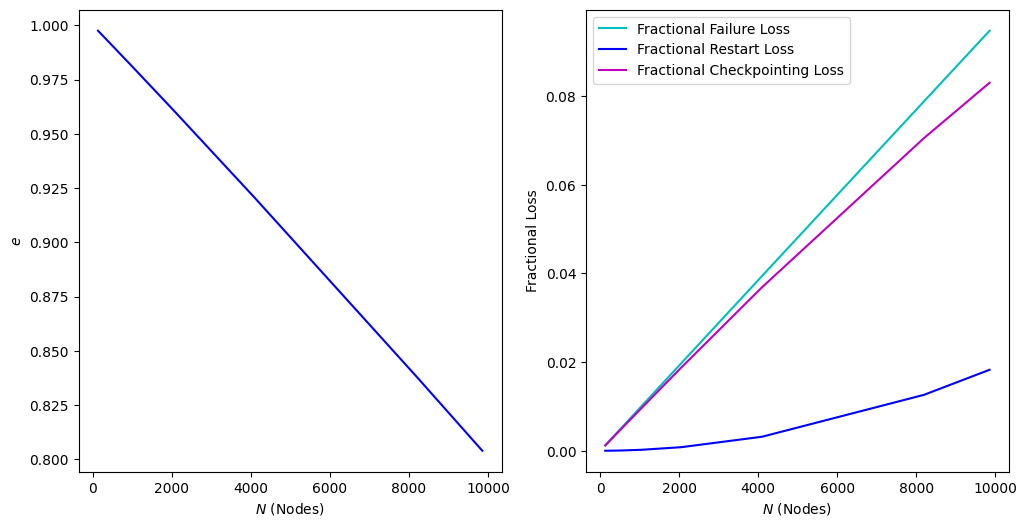

In [13]:
globals().update(base_case_params)

N_vals=np.array([128,256,512,1024,2048,4096,8194,nodes_total])
t=24

e_arr = []
l_F_arr = []
l_chk_arr = []
l_R_arr = []

for N in N_vals:
    fake_jobs=np.array([[N,t]])
    u_chk = per_checkpt_cost(fake_jobs, tau_c)
    u_c = optimum_checkpoint_cadence(fake_jobs, R_0, u_chk)
    u_F = per_failure_cost(u_c, u_chk, R_0)
    U_tot = per_job_usage(fake_jobs, u_c, u_chk, u_F, R_0, continuous=cont)
    L, L_F, L_chk, L_R = total_cost(fake_jobs, u_c, u_chk, R_0, tau_0, return_all=True, continuous=cont)

    e = 1 - L / U_tot
    e_arr.append(e)
    l_F = L_F / U_tot
    l_F_arr.append(l_F)
    l_chk = L_chk / U_tot
    l_chk_arr.append(l_chk)
    l_R =L_R /U_tot
    l_R_arr.append(l_R)

e_arr = np.array(e_arr)
l_F_arr = np.array(l_F_arr)
l_chk_arr = np.array(l_chk_arr)
l_R_arr = np.array(l_R_arr)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))

ax = axs[0]
ax.plot(N_vals, e_arr, "b-", label="Efficiency")

ax.set_xlabel("$N$ (Nodes)")
ax.set_ylabel("$e$")

ax = axs[1]
ax.plot(N_vals, l_F_arr, "c-", label="Fractional Failure Loss")
ax.plot(N_vals, l_R_arr, "b-", label="Fractional Restart Loss")
ax.plot(N_vals, l_chk_arr, "m-", label="Fractional Checkpointing Loss")
ax.legend()

ax.set_xlabel("$N$ (Nodes)")
ax.set_ylabel("Fractional Loss")

plt.show()


### <font color="darkblue"> Efficiency vs. Job Duration </font>

Let's explore how machine efficiency changes as a function of job duration $T$, for jobs of different sizes.  Here again we don't use the scaled database of *Polaris* production jobs, but rather just use fixed $N$ and $T$ for each case.


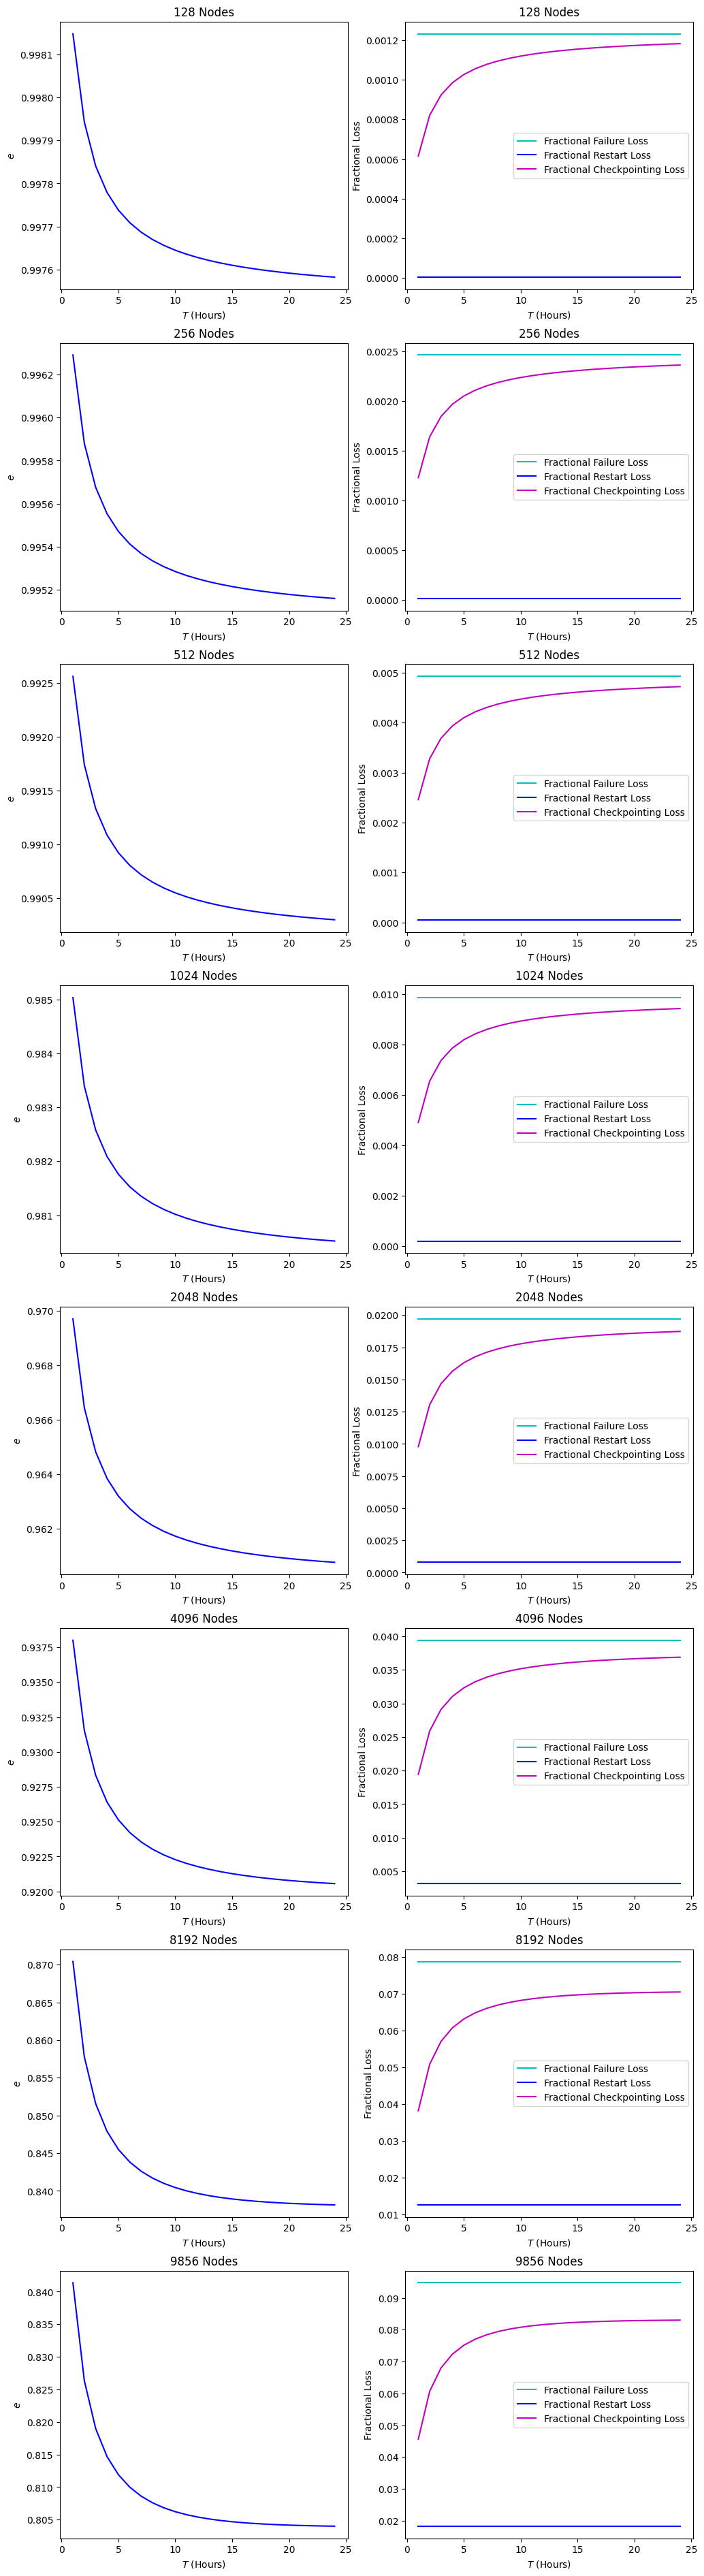

In [15]:
globals().update(base_case_params)

N_vals=np.array([128,256,512,1024,2048,4096,8192,nodes_total])
e_arr = []
l_F_arr = []
l_chk_arr = []
l_R_arr = []
t_arr = np.arange(24)+1
for N in N_vals:
    ee_arr = []
    ll_F_arr = []
    ll_chk_arr = []
    ll_R_arr = []
    for t in t_arr:
        fake_jobs=np.array([[N,t]])
        u_chk = per_checkpt_cost(fake_jobs, tau_c)
        u_c = optimum_checkpoint_cadence(fake_jobs, R_0, u_chk)
        u_F = per_failure_cost(u_c, u_chk, R_0)
        U_tot = per_job_usage(fake_jobs, u_c, u_chk, u_F, R_0)
        L, L_F, L_chk, L_R = total_cost(fake_jobs, u_c, u_chk, R_0, tau_0, return_all=True)

        e = 1 - L / U_tot
        ee_arr.append(e)
        l_F = L_F / U_tot
        ll_F_arr.append(l_F)
        l_chk = L_chk / U_tot
        ll_chk_arr.append(l_chk)
        l_R =L_R /U_tot
        ll_R_arr.append(l_R)
    e_arr.append(ee_arr)
    l_F_arr.append(ll_F_arr)
    l_chk_arr.append(ll_chk_arr)
    l_R_arr.append(ll_R_arr)
e_arr = np.array(e_arr)
l_F_arr = np.array(l_F_arr)
l_chk_arr = np.array(l_chk_arr)
l_R_arr = np.array(l_R_arr)
    
fig, axs = plt.subplots(ncols=2, nrows=len(N_vals),figsize=(12,6*len(N_vals)))

for row in range(len(N_vals)):
    ax = axs[row,0]
    ax.plot(t_arr, e_arr[row,:], "b-", label="Efficiency")

    ax.set_xlabel("$T$ (Hours)")
    ax.set_ylabel("$e$")
    ax.set_title(f"{N_vals[row]:d} Nodes")

    ax = axs[row,1]
    ax.plot(t_arr, l_F_arr[row,:], "c-", label="Fractional Failure Loss")
    ax.plot(t_arr, l_R_arr[row,:], "b-", label="Fractional Restart Loss")
    ax.plot(t_arr, l_chk_arr[row,:], "m-", label="Fractional Checkpointing Loss")
    ax.legend()

    ax.set_xlabel("$T$ (Hours)")
    ax.set_ylabel("Fractional Loss")
    ax.set_title(f"{N_vals[row]:d} Nodes")

plt.show()


This all makes good intuitive sense: the efficiency is in each case highest for the shortest duration jobs, which are exposed to the least risk. As duration increases, efficiency drops, and saturates at some value representing the long-duration statistical equilibrium efficiency for jobs of that size.  

The fractional losses (expected job loss divided by expected job duration) are shown in the right panels.  The only loss with time dependence is checkpointing loss, which grows as the expected number of checkpoint writes grows, until it saturates at durations where jobs almost certainly fail. The failure loss and restart loss, on the other hand, are constants in job duration.

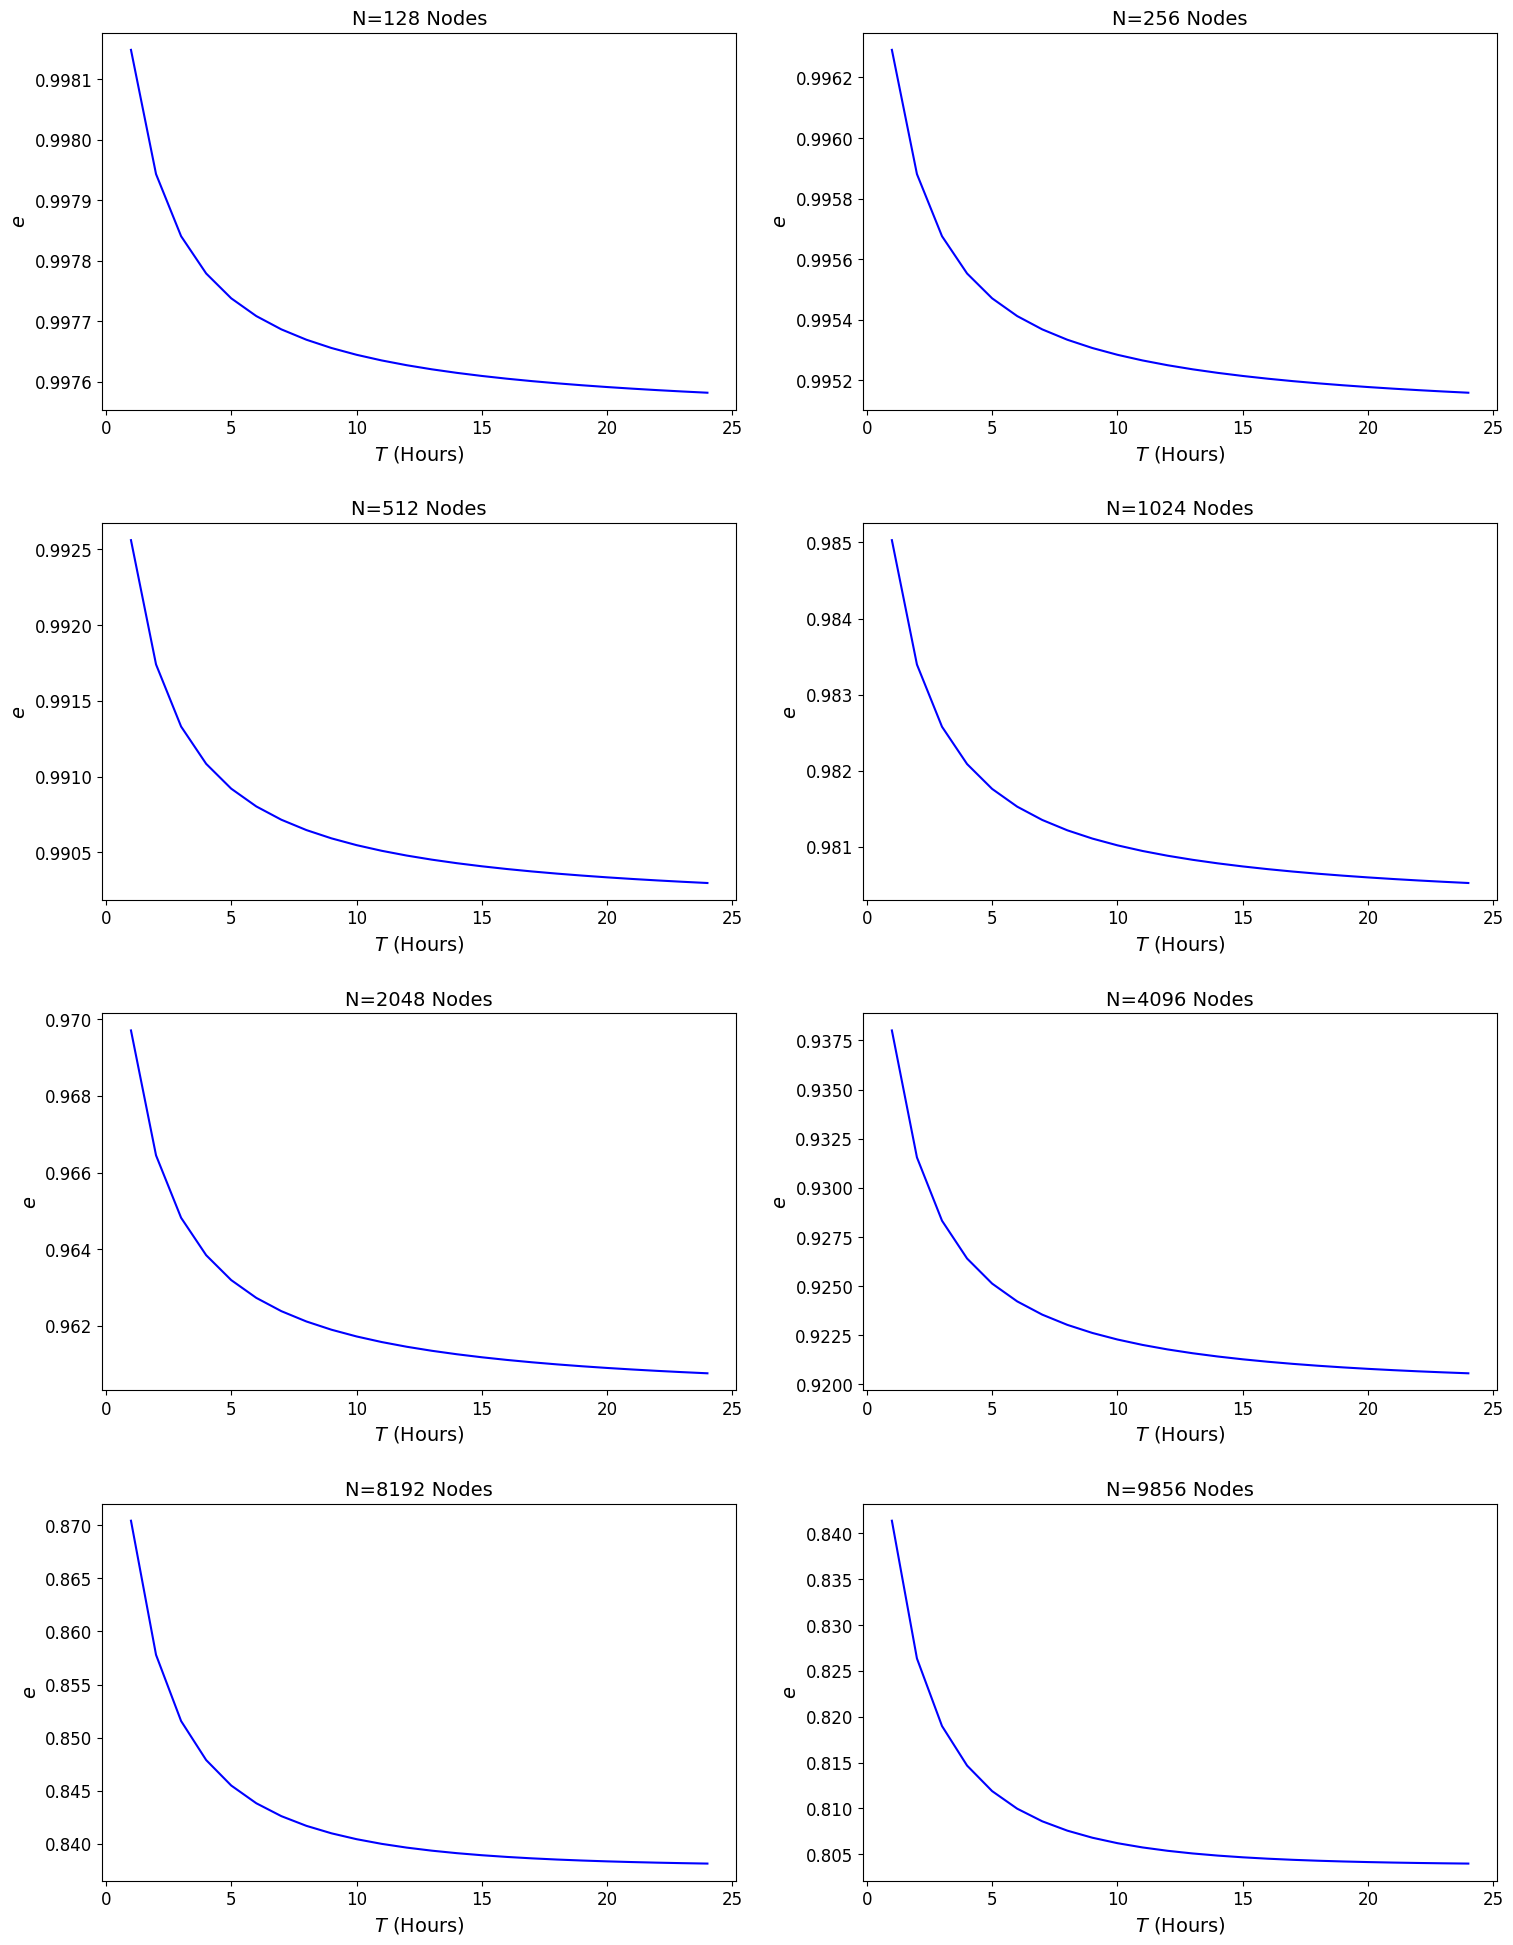

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=len(N_vals)//2,figsize=(18,6*len(N_vals)//2),
                        gridspec_kw={'hspace':0.30})

for idx in range(len(N_vals)):

    row = idx//2
    col = idx % 2
    ax = axs[row,col]
    ax.plot(t_arr, e_arr[idx,:], "b-", label="Efficiency")

    ax.set_xlabel("$T$ (Hours)", size=14)
    ax.set_ylabel("$e$",size=14)
    ax.set_title(f"N={N_vals[idx]:d} Nodes", size=14)
    ax.tick_params(labelsize=12)

plt.savefig("Efficiency_vs_Time.png", format="png",bbox_inches='tight')
plt.show()


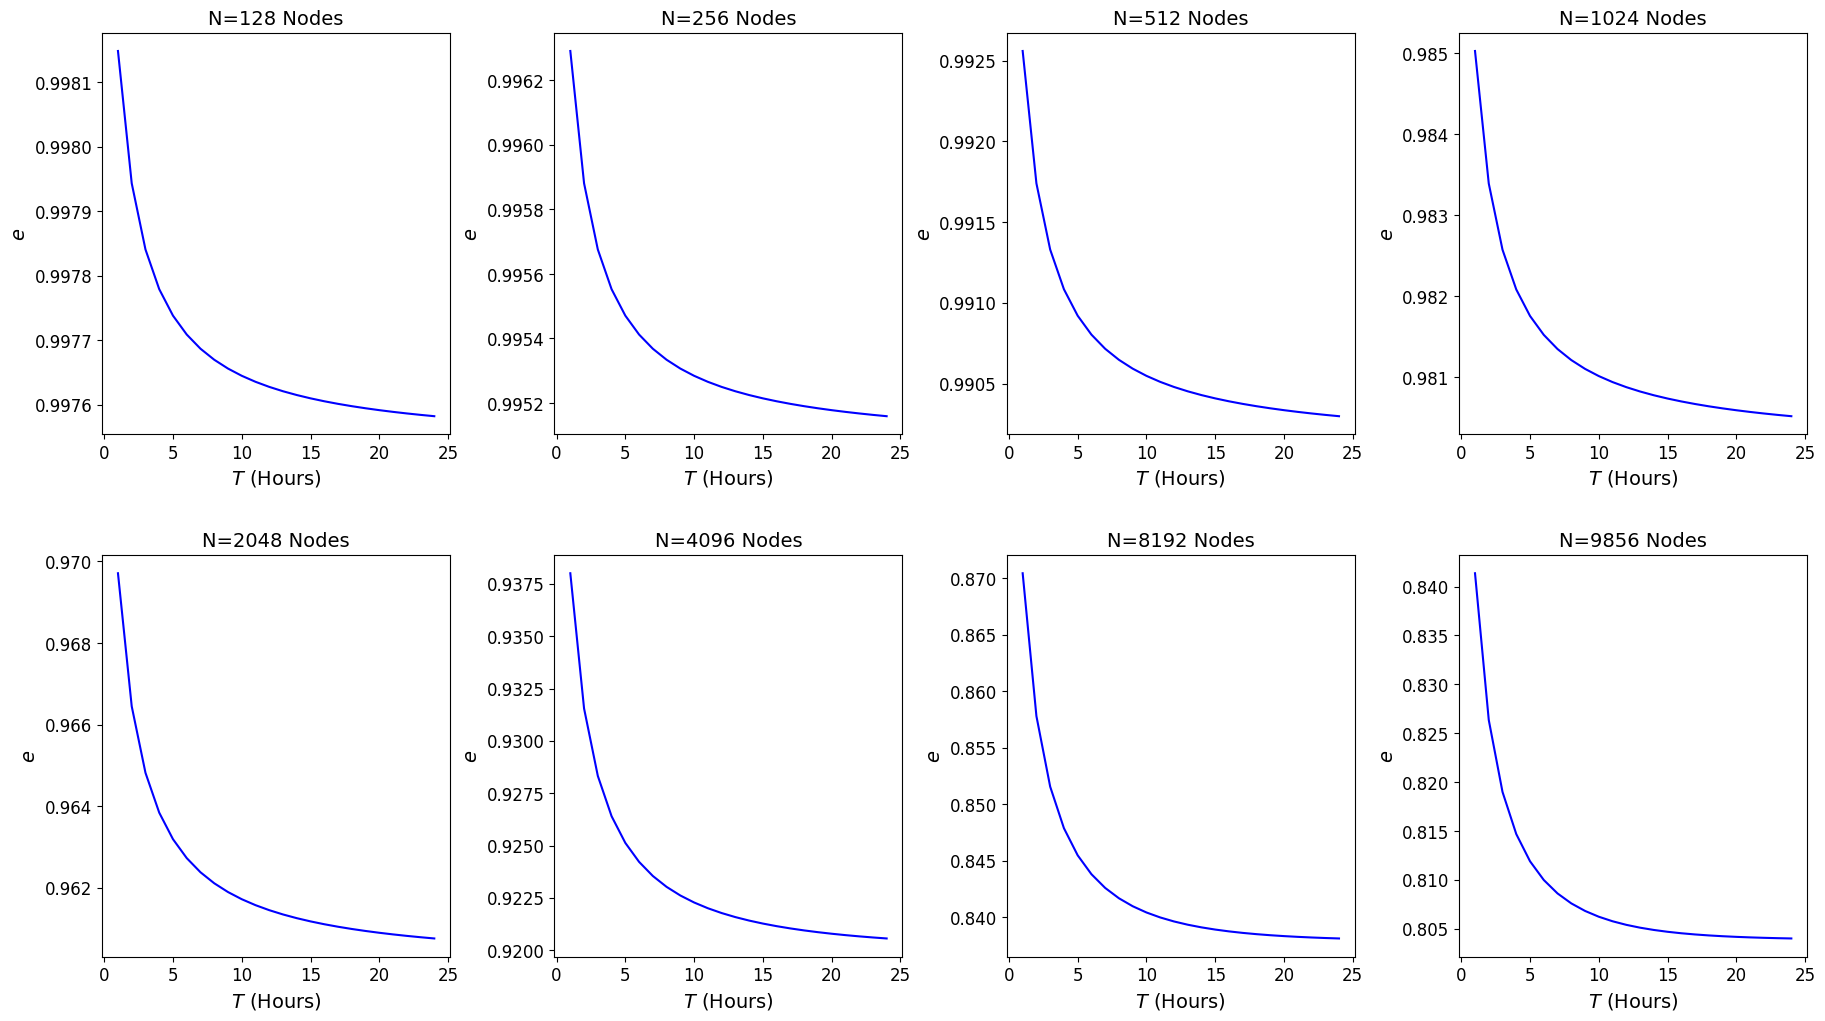

In [17]:
fig, axs = plt.subplots(ncols=4, nrows=len(N_vals)//4,figsize=(22,6*len(N_vals)//4),
                        gridspec_kw={'hspace':0.30, 'wspace':0.3})

for idx in range(len(N_vals)):

    row = idx//4
    col = idx % 4
    ax = axs[row,col]
    ax.plot(t_arr, e_arr[idx,:], "b-", label="Efficiency")

    ax.set_xlabel("$T$ (Hours)", size=14)
    ax.set_ylabel("$e$",size=14)
    ax.set_title(f"N={N_vals[idx]:d} Nodes", size=14)
    ax.tick_params(labelsize=12)

plt.savefig("Efficiency_vs_Time_2.png", format="png",bbox_inches='tight')
plt.show()


### <font color="darkblue"> Effect of Checkpointing Cadence </font>

Let's look at how checkpointing choices affect efficiency.

First: what happens if we do no prophylactic checkpointing at all?

In [18]:
globals().update(base_case_params)

u_chk = per_checkpt_cost(jobs_analysis, tau_c)
u_c = jobs_analysis[:,0]*jobs_analysis[:,1] # One checkpoint at the end of the job
u_F = per_failure_cost(u_c, u_chk, R_0)
U_tot = per_job_usage(jobs_analysis, u_c, u_chk, u_F, R_0, continuous=cont)

L, L_F, L_chk, L_R = total_cost(jobs_analysis, u_c, u_chk, R_0, tau_0, return_all=True, continuous=cont)

e = 1 - L / U_tot

l_F = L_F / U_tot
l_chk = L_chk / U_tot
l_R =L_R /U_tot

print(f"The usage efficiency is {e:.3f}.")
print(f"% Fractional Failure loss = {l_F:.4f}")
print(f"% Fractional Checkpoint loss = {l_chk:.4f}")
print(f"% Fractional Rerun loss = {l_R:.4f}")

The usage efficiency is 0.914.
% Fractional Failure loss = 0.0827
% Fractional Checkpoint loss = 0.0000
% Fractional Rerun loss = 0.0034


In the case of *Frontier*, the efficiency drops from 95.7% to 91.4%, a loss of 4.3%.

What happens if we deviate from optimal checkpointing rates?  Let's vary the checkpointing cadence and find out.

5% Drop points:
Cad. Frac = 0.229 ==> e = 0.905 ; Cad. Frac = 5.754 ==> e = 0.904
10% Drop points:
Cad. Frac = 0.132 ==> e = 0.853 ; Cad. Frac = 5.754 ==> e = 0.904


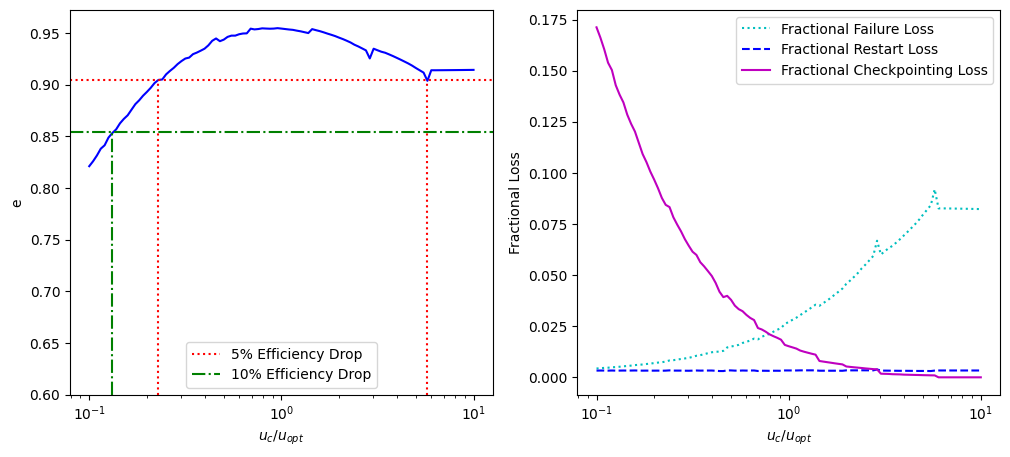

In [20]:
globals().update(base_case_params)
# cont=True
cadence_frac_vals = 10**np.linspace(-1,1,101)
e_vals = []
l_F_vals = []
l_chk_vals = []
l_R_vals = []
for cadence_frac in cadence_frac_vals:
    
    u_chk = per_checkpt_cost(jobs_analysis, tau_c)
    u_c = optimum_checkpoint_cadence(jobs_analysis, R_0, u_chk) * cadence_frac
    u_alloc = jobs_analysis[:,0]*jobs_analysis[:,1]
    u_c = np.where(u_c < u_alloc, u_c, u_alloc) # No checkpointing cadences greater than allocated usage
    u_F = per_failure_cost(u_c, u_chk, R_0)
    U_tot = per_job_usage(jobs_analysis, u_c, u_chk, u_F, R_0, continuous=cont)

    L, L_F, L_chk, L_R = total_cost(jobs_analysis, u_c, u_chk, R_0, tau_0, return_all=True, continuous=cont)

    e = 1 - L / U_tot
    e_vals.append(e)
    l_F_vals.append(L_F/U_tot)
    l_chk_vals.append(L_chk/U_tot)
    l_R_vals.append(L_R/U_tot)

e_vals = np.array(e_vals)
l_F_vals = np.array(l_F_vals)
l_chk_vals = np.array(l_chk_vals)
l_R_vals = np.array(l_R_vals)

emax = e_vals.max()
nmax = np.argmax(e_vals)

n_5_lo = np.argmin(np.abs(e_vals[:nmax]-(emax-0.05)))
e_5_lo = e_vals[n_5_lo]
f_5_lo = cadence_frac_vals[n_5_lo]
n_5_hi = nmax + np.argmin(np.abs(e_vals[nmax:]-(emax-0.05)))
e_5_hi = e_vals[n_5_hi]
f_5_hi = cadence_frac_vals[n_5_hi]

n_10_lo = np.argmin(np.abs(e_vals[:nmax]-(emax-0.1)))
e_10_lo = e_vals[n_10_lo]
f_10_lo = cadence_frac_vals[n_10_lo]
n_10_hi = nmax + np.argmin(np.abs(e_vals[nmax:]-(emax-0.1)))
e_10_hi = e_vals[n_10_hi]
f_10_hi = cadence_frac_vals[n_10_hi]

print("5% Drop points:\n"+ 
      f"Cad. Frac = {f_5_lo:.3f} ==> e = {e_5_lo:.3f} ; Cad. Frac = {f_5_hi:.3f} ==> e = {e_5_hi:.3f}")
print("10% Drop points:\n"+ 
      f"Cad. Frac = {f_10_lo:.3f} ==> e = {e_10_lo:.3f} ; Cad. Frac = {f_10_hi:.3f} ==> e = {e_10_hi:.3f}")


fig, axs = plt.subplots(ncols=2, figsize=(12,5))
ax = axs[0]
ax.plot(cadence_frac_vals, e_vals, "b-")

# ylo = e_vals.min()
ylo=0.6

ax.axhline(emax-0.05, color="r", ls=":", label=r"5% Efficiency Drop")
ax.plot([f_5_lo, f_5_lo], [ylo, e_5_lo], "r:")
ax.plot([f_5_hi, f_5_hi], [ylo, e_5_hi], "r:")

ax.axhline(emax-0.1, color="g", ls="-.", label=r"10% Efficiency Drop")
ax.plot([f_10_lo, f_10_lo], [ylo, e_10_lo], "g-.")
# ax.plot([f_10_hi, f_10_hi], [ylo, e_10_hi], "g-.")


ax.set_ylim(ymin=ylo)

ax.set_xscale("log")
ax.set_xlabel("$u_c/u_{opt}$")
ax.set_ylabel("e")
ax.legend()

ax = axs[1]
ax.plot(cadence_frac_vals, l_F_vals, "c:", label="Fractional Failure Loss")
ax.plot(cadence_frac_vals, l_R_vals, "b--", label="Fractional Restart Loss")
ax.plot(cadence_frac_vals, l_chk_vals, "m-", label="Fractional Checkpointing Loss")

ax.set_xscale("log")
ax.set_xlabel("$u_c/u_{opt}$")
ax.set_ylabel("Fractional Loss")
ax.legend()

plt.savefig("cadence_frac_sensitivity_v2.png", format="png")
plt.show()

### <font color="darkblue"> Efficiency versus Failure Rate </font>

Let's plot how efficiency varies as a function of $R_0$ for all of the machine nodes.

In [30]:
from cycler import cycler

globals().update(base_case_params)
# cont=True
# R_0 = 1 / (2.7 * 10624) ## 2.7 hrs MTBAI for the whole machine
# MTBAI = np.linspace(0.1,8,80)
R_0_vals = 10**np.linspace(-5,-3.5,80)

R_0_selected = np.array([2.0E-05, 1.0E-04, 2.0E-04])

e_arr = []
for R_0 in R_0_vals:
    u_chk = per_checkpt_cost(jobs_analysis, tau_c)
    u_c = optimum_checkpoint_cadence(jobs_analysis, R_0, u_chk)
    u_F = per_failure_cost(u_c, u_chk, R_0)
    U_tot = per_job_usage(jobs_analysis, u_c, u_chk, u_F, R_0, continuous=cont)

    L, L_F, L_chk, L_R = total_cost(jobs_analysis, u_c, u_chk, R_0, tau_0, return_all=True, continuous=cont)

    e = 1 - L / U_tot
    e_arr.append(e)

e_arr = np.array(e_arr)

e_selected = []
for R_0 in R_0_selected:
    # R_0 =1 / ( mbtai * 10624)
    u_chk = per_checkpt_cost(jobs_analysis, tau_c)
    u_c = optimum_checkpoint_cadence(jobs_analysis, R_0, u_chk)
    u_F = per_failure_cost(u_c, u_chk, R_0)
    U_tot = per_job_usage(jobs_analysis, u_c, u_chk, u_F, R_0, continuous=cont)

    L, L_F, L_chk, L_R = total_cost(jobs_analysis, u_c, u_chk, R_0, tau_0, return_all=True, continuous=cont)

    e = 1 - L / U_tot
    e_selected.append(e)
e_selected = np.array(e_selected)



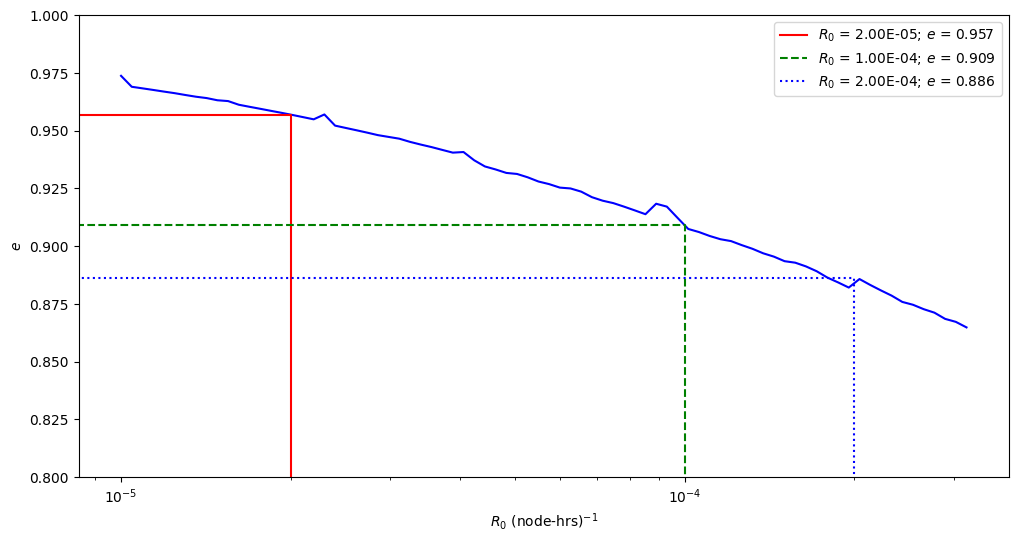

In [31]:
fig, ax = plt.subplots(figsize=(12,6))
default_cycler = (cycler(color=['r', 'g', 'b', 'y','m']) +
                  cycler(linestyle=['-', '--', ':', '-.','-']))
ax.set_prop_cycle(default_cycler)

ax.plot(R_0_vals, e_arr, "b-")

for idx in range(len(e_selected)):
    ax.plot([0,R_0_selected[idx], R_0_selected[idx]], [e_selected[idx], e_selected[idx],0],
            label="$R_0$" + f" = {R_0_selected[idx]:.2E}; "+"$e$" + f" = {e_selected[idx]:.3f}")

ax.set_xlabel("$R_0$ (node-hrs)$^{-1}$")
ax.set_xscale("log")
ax.set_ylabel("$e$")
ax.set_ylim(ymin=0.8,ymax=1)
# ax.set_xlim(xmin=0, xmax=5.5)
# ax.set_title("MTBAI for 10,624 Nodes")

ax.legend()

plt.savefig("e_vs_R0.png", format="png")

plt.show()

### <font color="darkblue"> Efficiency vs Bandwidth

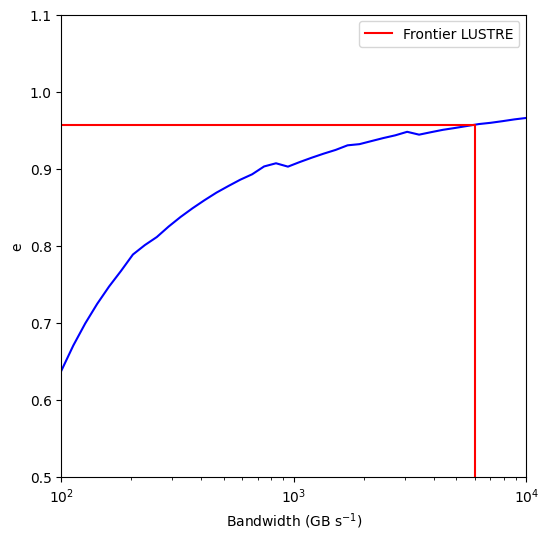

In [35]:
globals().update(base_case_params)

# "tau_c": 5.1 /(3600*128), # Checkpoint write time per node (hrs). This assumes writing
#                              # 200 GB at 39 GB/s to 128 DAOS nodes (5 TB/s aggregate to 128 DAOS nodes)
# tau_c = (200 / 650) / 3600 # 200GB at 650 GB/s, in hours.
# cont=True

bandwidth = 10**np.linspace(2,4,40)
tau_c_vals = 200 / (bandwidth * 3600)

e_vals = []
for tau_c in tau_c_vals:
    u_chk = per_checkpt_cost(jobs_analysis, tau_c)
    u_c = optimum_checkpoint_cadence(jobs_analysis, R_0, u_chk)
    u_F = per_failure_cost(u_c, u_chk, R_0)
    U_tot = per_job_usage(jobs_analysis, u_c, u_chk, u_F, R_0, continuous=cont)

    L, L_F, L_chk, L_R = total_cost(jobs_analysis, u_c, u_chk, R_0, tau_0, return_all=True, continuous=cont)

    e = 1 - L / U_tot
    e_vals.append(e)
e_vals = np.array(e_vals)

bandwidth_selected = np.array([6000])
tau_c_selected = 200 / (bandwidth_selected * 3600)
names_selected = ["Frontier LUSTRE"]
e_selected = []
for tau_c in tau_c_selected:
    u_chk = per_checkpt_cost(jobs_analysis, tau_c)
    u_c = optimum_checkpoint_cadence(jobs_analysis, R_0, u_chk)
    u_F = per_failure_cost(u_c, u_chk, R_0)
    U_tot = per_job_usage(jobs_analysis, u_c, u_chk, u_F, R_0, continuous=cont)

    L, L_F, L_chk, L_R = total_cost(jobs_analysis, u_c, u_chk, R_0, tau_0, return_all=True, continuous=cont)

    e = 1 - L / U_tot
    e_selected.append(e)

fig,ax = plt.subplots(figsize=(6,6))

ax.set_prop_cycle(default_cycler)

ax.plot(bandwidth, e_vals, "b-")

for idx in range(len(e_selected)):
    ax.plot([1E2, bandwidth_selected[idx], bandwidth_selected[idx]], [e_selected[idx], e_selected[idx], 0],
            label=names_selected[idx])

ax.set_xscale("log")
ax.set_xlim(xmin=1E2, xmax=1E4)
ax.set_ylim(ymin=0.5, ymax=1.1)
ax.legend()
ax.set_xlabel("Bandwidth (GB s$^{-1}$)")
ax.set_ylabel("e")

plt.savefig("e_vs_bandwidth.png", format="png")

plt.show()